In [2]:
import os
from snn_delays.config import CHECKPOINT_PATH
from snn_delays.utils.model_loader import ModelLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from snn_delays.utils.results_utils import get_results, get_states
from snn_delays.utils.visualization_utils import plot_losses

ckpt_dir2 = 'abl8_addtask_st_T250'

sweep_params_names = {
    'U_1': ['rnn','mf', 'f', 'rd'],
    'structure':['2l'],
    'tau_m':['ht'],
    'T_freeze_taus':['tt']
    }

from snn_delays.utils.dataset_loader import DatasetLoader

time_window = 250
batch_size = 128 # 128: anil kag
dataset = 'addtask_episodic'

DL = DatasetLoader(dataset=dataset, caching='', num_workers=0, batch_size=batch_size, total_time=time_window)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

attributes = ['train_loss', 'spike_state', 'mem_state', 'model']

trn_loss, spikes, mems,  models, refs, preds, = get_states(ckpt_dir2, sweep_params_names, attributes, rpts=2, mode='', loader=test_loader, batch_size=batch_size)

returning dict_keys(['train_loss', 'spike_state', 'mem_state', 'model', 'refs', 'imgs'])


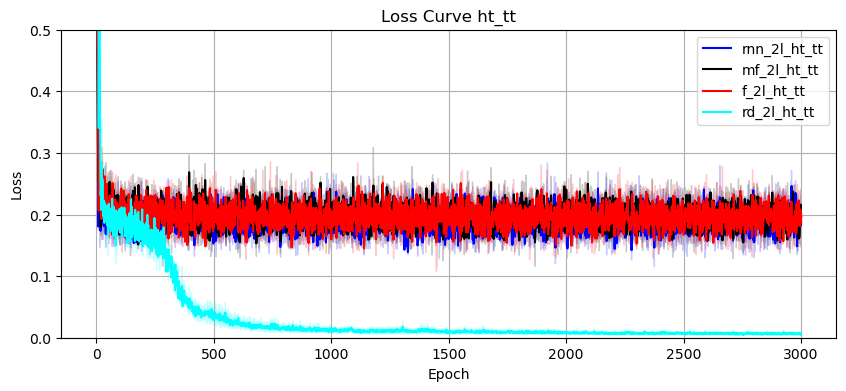

In [3]:
filtered_ht_tt = {key:value for key, value in trn_loss.items() if 'ht_tt' in key}
#filtered_ht_ft = {key:value for key, value in trn_loss.items() if 'ht_ft' in key}

import itertools
colors = itertools.cycle(["blue", "black", 'red', 'cyan'])

ylim = 0.5

plt.figure(figsize=(10,4))
for key, value in filtered_ht_tt.items():
    plt.title('Loss Curve ht_tt')
    plot_losses(value, label=key, color=next(colors))
    plt.ylim(0, ylim)
# plt.subplot(122)
# for key, value in filtered_ht_ft.items():
#     plt.title('Loss Curve ht_ft')
#     plot_losses(value, label=key, color=next(colors))
#     plt.ylim(0, ylim)

# plot_losses(tstloss_d['f_d_2l_hm_ft'], color='red')

-0.001826461
0.013654888
-0.08541208
-0.00628474


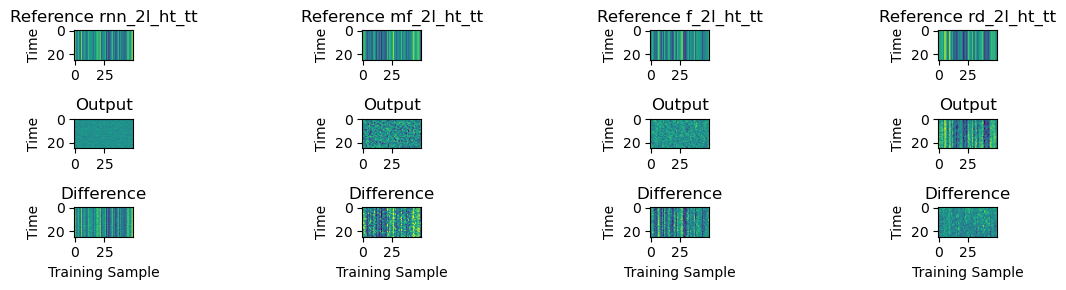

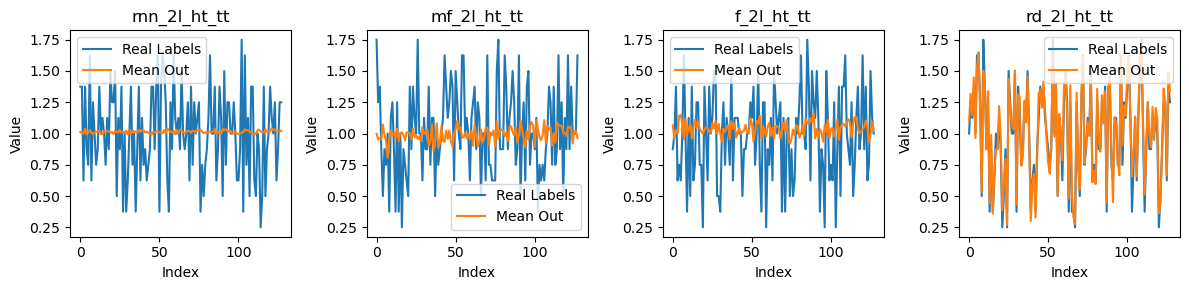

In [4]:
from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4

mems_ht_tt = {key:value for key, value in mems.items() if 'ht_tt' in key}

refs_plot1 = {}
outs_plot1 = {}

# Create a figure with 3 rows and N columns (for stacking results horizontally)
fig, axes = plt.subplots(3, 4, figsize=(12, 3))
for i, model_name in enumerate(mems_ht_tt.keys()):
    ref = refs[model_name][0][:,:int(0.1*time_window),0].T.cpu().numpy()
    out = mems[model_name][0]['output'][int(0.9*time_window):].detach().cpu().numpy()    
    plot_add_task(out[:,:50, :], ref[:, :50], axes[:, i], model_name)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
for i, model_name in enumerate(mems_ht_tt.keys()):
    ref = refs[model_name][0]
    out = mems[model_name][0]['output'][int(0.9*time_window):].detach().cpu().numpy()    
    plt.subplot(1,4,i+1)
    plot_add_task2(out, ref)
    plt.title(model_name)
plt.tight_layout()
plt.show()

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


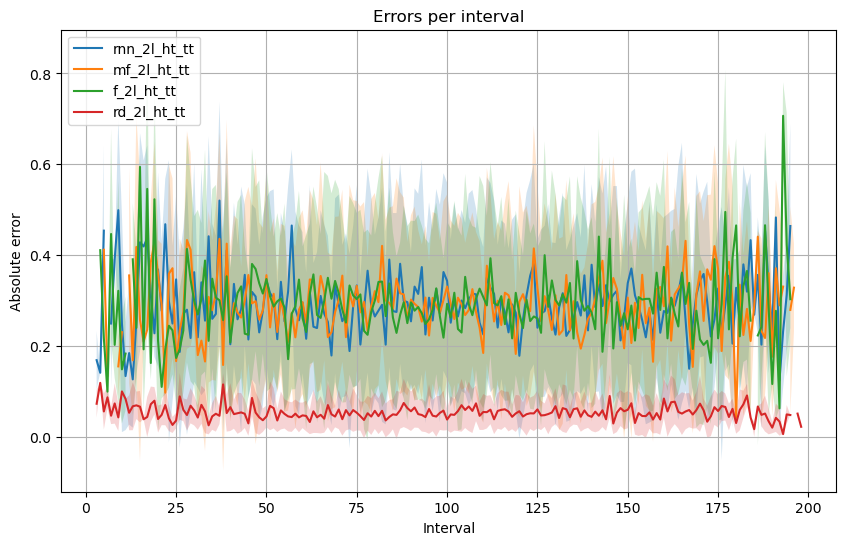

: 

In [ ]:
import torch
import numpy as np
from snn_delays.utils.train_utils import propagate_batch

def get_errors_per_lapse(snn, num_trials):

    errors_per_lapse = [ [] for x in range(int(0.8*snn.win))]

    for trial in range(num_trials):

        _, labels = propagate_batch(snn, test_loader)
        ref = labels[:,:5,0].T.cpu().numpy()
        out = snn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

        input_times = snn.spike_state['input'][:,:,1]

        outs = np.mean(out, axis=0)
        refs = np.mean(ref, axis=0)

        for sample in range(input_times.shape[1]):
            spike_times = torch.where(input_times[:, sample] == 1)[0]  # Get spike times
            dif = (spike_times[1] - spike_times[0]).item()
            errors_per_lapse[dif].append(abs(outs[sample]-refs[sample]))
    
    return errors_per_lapse

def plot_errors_per_lapse(errors, label='Mean loss', linestyle='-'):

    # Example data: replace `nested_loss_lists` with your actual data
    #nested_loss_lists = tstloss_d['f_d_2l_hm_ft']

    # Ensure all lists have the same length and epoch indices
    #epochs = [entry[0] for entry in nested_loss_lists[0]]  # Epochs
    times = range(int(0.8*time_window))
    #all_losses = [np.array([entry[1] for entry in lst]) for lst in nested_loss_lists]

    mean_losses = np.array([np.mean(err) for err in errors])
    std_losses = np.array([np.std(err) for err in errors])

    # # Calculate average and standard deviation
    # mean_losses = np.mean(all_losses, axis=0)
    # std_losses = np.std(all_losses, axis=0)

    # Plot the average loss curve with error bars
    #plt.figure(figsize=(10, 6))
    plt.plot(times, mean_losses, label=label, linestyle=linestyle)
    #plt.fill_between(epochs, mean_losses - std_losses, mean_losses + std_losses, color=color, alpha=0.2, label='±1 Std Dev')
    plt.fill_between(times, mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
    #plt.title("Average Loss Curve")
    plt.xlabel("Interval")
    plt.ylabel("Absolute error")
    plt.legend()
    plt.grid(True)
    
    return plt.gca()

plt.figure(figsize=(10, 6))
for model_config in mems_ht_tt.keys():
    error = get_errors_per_lapse(models[model_config][0], 20)
    plot_errors_per_lapse(error, model_config)
    plt.title('Errors per interval')
